# Kaggle: Titanic Challenge
## Coded by Daniel Wilcox

This is a notebook showing the process in predicting the survivors of the Titanic.

In [1]:
#Misc.
import os
import pickle
import glob
import re

#Dataframs and arrays
import pandas as pd
import numpy as np

#Statistics
from scipy.stats import randint, reciprocal, expon, uniform

#Graphics
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

#Dataset manipulation
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.base import clone

#Fills in values to empty data locations
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

#Pipelines
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion

#Creating custom Transformers
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

#Model Scoring
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score


from sklearn.metrics import confusion_matrix

#Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


#Classifier Models:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.svm import NuSVC 

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier 
from sklearn.linear_model import Perceptron 
from sklearn.linear_model import RidgeClassifier 

from sklearn.gaussian_process import GaussianProcessClassifier 

from sklearn.naive_bayes import BernoulliNB 
from sklearn.naive_bayes import GaussianNB 

from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier 

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 

from sklearn.neural_network import MLPClassifier 

from sklearn.ensemble import VotingClassifier


In [2]:
#The Location to save the dataset
TITANIC_PATH = "datasets/titanic"
TITANIC_URL = "https://github.com/Daniel-Wilcox/ADA-874-2019/blob/master/datasets/titanic/"
train_name = "train.csv" 
test_name = "test.csv" 


#The Location to save the models
PICKLE_PATH = "PickleModels/Titanic"

In [3]:
#Pickle functions

#Saving and storing the model
def save_pickle(model_name, model, pic_path=PICKLE_PATH):
    print("Saving model...")
    
    cwd = os.getcwd()
    os.chdir(cwd+"/"+pic_path)
        
    f = open(model_name, "wb")
    pickle.dump(model, f)
    f.close()
    
    os.chdir(cwd)
    print("Saved "+model_name+" successfully!\n")
    return None
    
    
#Retrieving and loading the model
def load_pickle(model_name, pic_path=PICKLE_PATH):
    print("Loading "+model_name+" from Pickle file...")
    
    cwd = os.getcwd()
    os.chdir(cwd+"/"+pic_path)
    
    f = open(model_name, "rb")
    p = pickle.load(f)
    f.close()
    
    os.chdir(cwd)
    print(model_name+" successfully loaded!\n")
    return p

#Check whether the pickel exists
def pickle_exist(model_name, pic_path=PICKLE_PATH):
    #check if pickle file exists
    print("Checking if pickle directory exists...")
    if not os.path.isdir(pic_path):
        os.makedirs(pic_path)
        print("Directory does NOT exists")
        print("Creating directory")
    
    else: 
        print("Directory exists")
        
    if os.path.isfile(pic_path+"/"+model_name):
        print("Pickle file does exists...")
        return True
    else:
        print("Pickle file does NOT exists...")
        return False

In [4]:
def load_Titanic_data(file_name, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, file_name)
    return pd.read_csv(csv_path)
        
    
def get_Titanic_data(file_name, titanic_url=TITANIC_URL, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, file_name)
    
    print("Checking if directory exists...")
    if not os.path.isdir(titanic_path):
        os.makedirs(titanic_path)
        print("Creating directory")
    
    else: 
        print("Directory exists") 
            
        if os.path.isfile(csv_path):
            print(file_name + " file does exists...")
            print("extracting " + file_name)
            
            titanic = load_Titanic_data(file_name)
            print("\nSuccess!")
            return titanic
        
        else:
            print(file_name + " file doesn't exists...")
            print("Download .csv from Kaggle!")

            return None
                   

In [5]:
def notify(title, text):
    os.system("""
              osascript -e 'display notification "{}" with title "{}"'
              """.format(text, title))
    os.system('osascript -e "beep 1"')
    

In [6]:
Train = get_Titanic_data(train_name)
Test = get_Titanic_data(test_name)

full_data = pd.concat(objs=[Train, Test], axis=0, sort=False).reset_index(drop=True)

#Fill "survived" of test data in titanic as 0:
full_data["Survived"] = full_data["Survived"].fillna(0)
fl_sur = full_data["Survived"].copy()
full_data.head()

Checking if directory exists...
Directory exists
train.csv file does exists...
extracting train.csv

Success!
Checking if directory exists...
Directory exists
test.csv file does exists...
extracting test.csv

Success!


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [8]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [9]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Survived       1309 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [10]:
full_data.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


### Variable - Definition                              - Key
1. survival - Survival                                - 0/1 = No/Yes
2. pclass   - Ticket class                            - 1,2,3 = 1st, 2nd, 3rd class
3. sex      - Sex                                     - male, female
4. Age      - Age in years                            - ...
5. sibsp    - # of siblings/spouses on the Titanic    - ...
6. parch    - # of parents/children on the Titanic    - ...
7. ticket   - Ticket number                           - ...
8. fare     - Passenger fare                          - ...
9. cabin    - Cabin number                            - ...
10. embarked - Port of Embarkation                     - C = Cherbourg, Q = Queenstown, S = Southampton


In [11]:
full_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
sur = Train["Survived"].value_counts() / len(Train)
print("From the Train.csv dataset provided:")
print("{:.2f}% Survived\n{:.2f}% Died".format(100*sur[1],100*sur[0]))

From the Train.csv dataset provided:
38.38% Survived
61.62% Died


In [13]:
#Separtate labels from features
y_tr = Train["Survived"].copy()
X_tr = Train.drop("Survived", axis=1)

#Columns for Cabin Transformer
list_add_1 = Train[list(set(Train.columns))].columns

#Columns for Title Transformer
list_add_2 = list_add_1.insert(len(list_add_1)+1, 'has_cabin')

#Columns for Age/Fare Transformer
list_add_3 = list_add_2.insert(len(list_add_2)+1, 'Title')

#Columns for Family Transformer
list_add_4 = list_add_3.insert(len(list_add_3)+1, 'age_group')
list_add_4 = list_add_4.insert(len(list_add_4)+1, 'Fare_group')

In [14]:
#--------------------------------------------------------------------------------
class fix_cabin(BaseEstimator, TransformerMixin):
    def __init__(self, add_col):
        self.add_col = add_col    

    def fit(self, X, y=None):
        return(self)

    def transform(self, X):  
        df = X[self.add_col]
        
        #Fill all NaN with 'U' (Unknown Cabin)
        df["Cabin"] = df["Cabin"].fillna('U')
        df["Cabin"] = df["Cabin"].map(lambda x: x[0])
        
        #Make new feature - has_cabin = 0 if Cabin is unknown (U)
        df["has_cabin"] = 1
        df["has_cabin"].loc[df["Cabin"] == 'U'] = 0  

        return df 
    
#--------------------------------------------------------------------------------    
class fix_age_fare(BaseEstimator, TransformerMixin):
    def __init__(self, add_col):
        self.add_col = add_col
                

    def fit(self, X, y=None):
        return(self)

    
    def transform(self, X):  
        df = X[self.add_col]

        #Group by "Title", "Sex" and "Pclass"
        fill_Nan = df.groupby(["Title", "Sex", "Pclass"])
        
        #Fill NaN's with 0
        df["Age"].loc[(df["Age"] == 0)] = np.NaN
        df["Fare"].loc[(df["Fare"] == 0)] = np.NaN
        
        #Fill "Age" and "Fare" with grouped median values
        df["Age"] = fill_Nan["Age"].apply(lambda x: x.fillna(x.median()))
        df["Fare"] = fill_Nan["Fare"].apply(lambda x: x.fillna(x.median()))
        
        #Create features of binned "Age" and "Fare"      
        df["age_group"] = pd.qcut(df.Age, q=4, labels=False)   
        df["Fare_group"] = pd.qcut(df.Fare, q=6, labels=False)     
        
        return df
    
#--------------------------------------------------------------------------------   
class add_fam(BaseEstimator, TransformerMixin):
    def __init__(self, add_col):
        self.add_col = add_col

    def fit(self, X, y=None):
        return(self)

    def transform(self, X):  
        df = X[self.add_col]
        
        #Create feature that determines the size of the family
        df["Fam_size"] = df.loc[:,"SibSp"] + df.loc[:,"Parch"] + 1
        
        #Create feature that determines whether person is alone
        df["Alone"] = 0
        df["Alone"].loc[(df["SibSp"]==0) & (df["Parch"]==0)] = 1
        
        #Create feature that determines mean cost per family member
        df["fare_per_fam"] = df["Fare"]/df["Fam_size"]
        
        #Extracts the Surname
        df["surname"] = df["Name"].str.split(",", n = 1, expand = True)[0]
        
        #Extracts shortened ticket
        df["tic"] = df["Ticket"].str[:-2]
        
        #Create feature that assigns unique family code
        f_Id = lambda x: '-'.join(x.map(str))
        df["Fam_ID"] = df[["surname", "Pclass", "Embarked", "Cabin", "tic"]
                            ].apply(f_Id, axis=1)
        
        #Family code is "Alone" if person went alone
        df["Fam_ID"].loc[(df["Alone"] == 1)] = 'Alone'
        
        
        #Create feature Fam_ID_survived
        df["Fam_ID_survived"] = 0
        df["Fam_ID_survived"] = df.groupby(["Fam_ID"])["Survived"].transform(lambda x: x.eq(1).sum())
        df["Fam_ID_survived"].loc[(df["Fam_ID"] == 'Alone')] = df["Survived"]
        
        #Create feature Fam_survived_rate= Fam_ID_survived/Fam_size
        df["Fam_survived_rate"] = df["Fam_ID_survived"]/df["Fam_size"]

        
        
        #Drop columns
        df.drop(labels=["surname", "Fam_ID_survived", "tic", "Name", "Survived"], axis = 1, inplace = True)

        return df    
    
#--------------------------------------------------------------------------------   
class add_title(BaseEstimator, TransformerMixin):
    def __init__(self, add_col):
        self.add_col = add_col

    def fit(self, X, y=None):
        return(self)

    def transform(self, X):  
        df = X[self.add_col]
        
        #Create feature of honorific (eg Mr, Miss, ...)
        df["Title"] = df["Name"].str.extract(r'((?<=, )[A-Za-z ]+(?=.))', expand = True)[0]

        #Convert  to numeric
        #Rare honorifics: 0
        df["Title"] = df.loc[:,"Title"].replace(
                ['Don', 'Rev', 'Dr', 'Mme', 'Major', 
                 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 
                 'the Countess', 'Jonkheer', 'Dona'],
                 'Rare')
        
        #Female honorifics: 1
        df["Title"] = df.loc[:,"Title"].replace(
                ['Mrs','Miss','Ms'], 'Women/Girls')

        #Young male honorifics: 2
        df["Title"] = df.loc[:,"Title"].replace(
                ['Master'], 'Boys')
        
        #Adult male honorifics: 3
        df["Title"] = df.loc[:,"Title"].replace(
                ['Mr'], 'Men') 
                
        return df      
    
class fix_emb(BaseEstimator, TransformerMixin):
    def __init__(self, add_col):
        self.add_col = add_col    

    def fit(self, X, y=None):
        return(self)

    def transform(self, X):  
        df = X[self.add_col]
        
        #Find most common Embarked location
        freq_em = df["Embarked"].value_counts().index[0]
        df["Embarked"] = df["Embarked"].fillna(freq_em)

        return df     
    
    
#Add Features
add_pipeline = Pipeline([
    ('fix_cabin', fix_cabin(list_add_1)),
    ('fix_emb', fix_emb(list_add_2)),
    ('add_title', add_title(list_add_2)),
    ('fix_age_fare', fix_age_fare(list_add_3)),
    ('add_fam', add_fam(list_add_4))   
]) 






titanic = add_pipeline.fit_transform(full_data)
titanic["Survived"] = fl_sur
titanic.head()



/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Cabin,Parch,Ticket,SibSp,Age,Pclass,PassengerId,Sex,Fare,Embarked,has_cabin,Title,age_group,Fare_group,Fam_size,Alone,fare_per_fam,Fam_ID,Fam_survived_rate,Survived
0,U,0,A/5 21171,1,22.0,3,1,male,7.2500,S,0,Men,0,0,2,0,3.62500,Braund-3-S-U-A/5 211,0.0,0.0
1,C,0,PC 17599,1,38.0,1,2,female,71.2833,C,1,Women/Girls,3,5,2,0,35.64165,Cumings-1-C-C-PC 175,0.5,1.0
2,U,0,STON/O2. 3101282,0,26.0,3,3,female,7.9250,S,0,Women/Girls,1,1,1,1,7.92500,Alone,1.0,1.0
3,C,0,113803,1,35.0,1,4,female,53.1000,S,1,Women/Girls,2,4,2,0,26.55000,Futrelle-1-S-C-1138,0.5,1.0
4,U,0,373450,0,35.0,3,5,male,8.0500,S,0,Men,2,1,1,1,8.05000,Alone,0.0,0.0


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


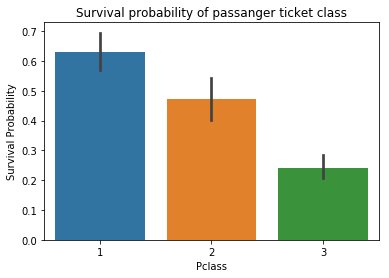

In [15]:
#Pclass

fig = sns.barplot(x="Pclass",y="Survived",data=titanic[0:len(Train)])
fig = fig.set(xlabel="Pclass", ylabel="Survival Probability")
fig = plt.title("Survival probability of passanger ticket class")


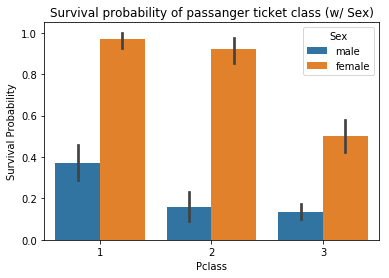

In [16]:
#Pclass w/ Sex

fig = sns.barplot(x="Pclass",y="Survived", hue="Sex", data=titanic[0:len(Train)])
fig = fig.set(xlabel="Pclass", ylabel="Survival Probability")
fig = plt.title("Survival probability of passanger ticket class (w/ Sex)")


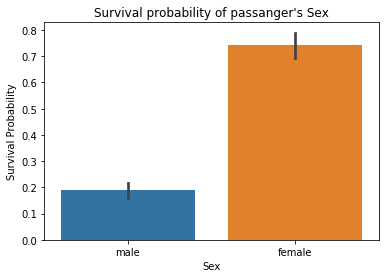

In [17]:
#Sex
fig = sns.barplot(x="Sex",y="Survived",data=titanic[0:len(Train)])
fig = fig.set(xlabel="Sex", ylabel="Survival Probability")
fig = plt.title("Survival probability of passanger's Sex")


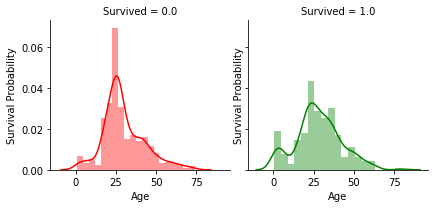

In [18]:
#Age

d = {'color': ['r', 'g']}   
fig = sns.FacetGrid(titanic[0:len(Train)], col='Survived',  hue_kws=d, hue='Survived')
fig = fig.map(sns.distplot, "Age")   

fig = fig.set(xlabel="Age", ylabel="Survival Probability")

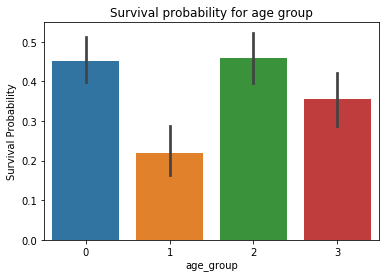

In [19]:
#age_group
fig = sns.barplot(x="age_group",y="Survived",data=titanic[0:len(Train)])
fig = fig.set(xlabel="age_group", ylabel="Survival Probability")
fig = plt.title("Survival probability for age group")


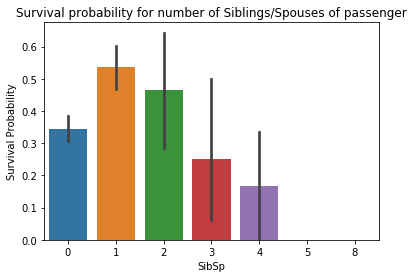

In [20]:
#SibSp

fig = sns.barplot(x="SibSp",y="Survived",data=titanic[0:len(Train)])
fig = fig.set(xlabel="SibSp", ylabel="Survival Probability")
fig = plt.title("Survival probability for number of Siblings/Spouses of passenger")


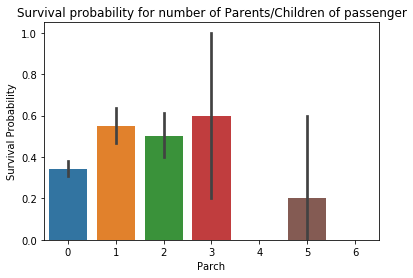

In [21]:
#Parch

fig = sns.barplot(x="Parch",y="Survived",data=titanic[0:len(Train)])
fig = fig.set(xlabel="Parch", ylabel="Survival Probability")
fig = plt.title("Survival probability for number of Parents/Children of passenger")


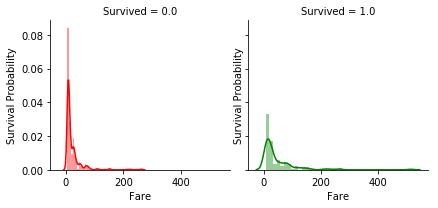

In [22]:
#Fare

d = {'color': ['r', 'g']}   
fig = sns.FacetGrid(titanic[0:len(Train)], col='Survived',  hue_kws=d, hue='Survived')
fig = fig.map(sns.distplot, "Fare")   

fig = fig.set(xlabel="Fare", ylabel="Survival Probability")

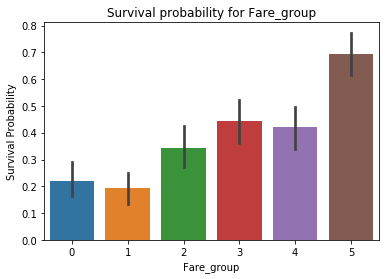

In [23]:
#Fare_group 
fig = sns.barplot(x="Fare_group",y="Survived",data=titanic[0:len(Train)])
fig = fig.set(xlabel="Fare_group", ylabel="Survival Probability")
fig = plt.title("Survival probability for Fare_group")


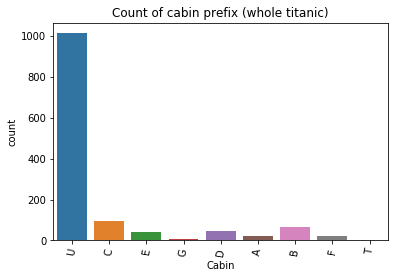

In [24]:
#Cabin
fig = sns.countplot(x="Cabin",data=titanic)
fig = plt.setp(fig.get_xticklabels(), rotation=80) 
fig = plt.title("Count of cabin prefix (whole titanic)")

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


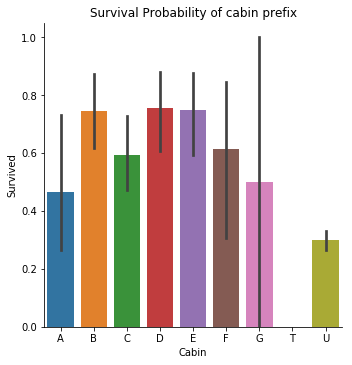

In [25]:
order_cabin = ['A','B','C','D','E','F','G','T','U']
fig = sns.factorplot(x="Cabin", y="Survived", data=titanic[0:len(Train)],
                    kind="bar", order=order_cabin)
fig = plt.title("Survival Probability of cabin prefix")


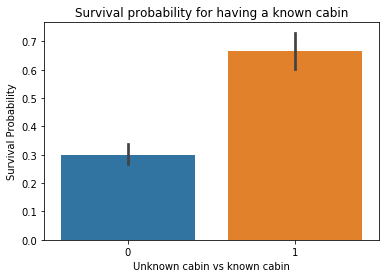

In [26]:
#has_cabin   
fig = sns.barplot(x="has_cabin", y="Survived", data=titanic[0:len(Train)])
fig = fig.set(xlabel="Unknown cabin vs known cabin", ylabel="Survival Probability")
fig = plt.title("Survival probability for having a known cabin")

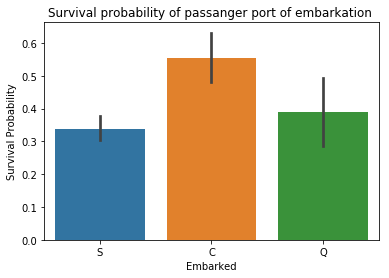

In [27]:
#Embarked

fig = sns.barplot(x="Embarked",y="Survived",data=titanic[0:len(Train)])
fig = fig.set(xlabel="Embarked", ylabel="Survival Probability")
fig = plt.title("Survival probability of passanger port of embarkation ")


In [28]:
#feature eng:
Full_set = pd.concat(objs=[Train, Test], axis=0).reset_index(drop=True)

#Name: f_name, honorifics. sur_name
honorifics = [i.split(",")[1].split(".")[0].strip() for i in Full_set["Name"]]
Full_set["Title"] = pd.Series(honorifics)
Full_set.Title.unique()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

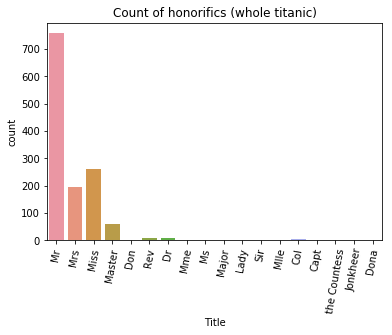

In [29]:
fig = sns.countplot(x="Title",data=Full_set)
fig = plt.setp(fig.get_xticklabels(), rotation=80) 
fig = plt.title("Count of honorifics (whole titanic)")


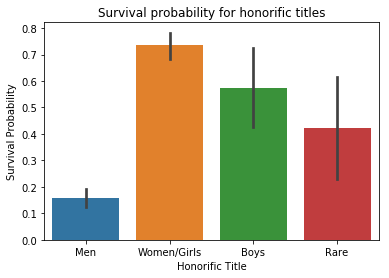

In [30]:
fig = sns.barplot(x="Title",y="Survived",data=titanic[0:len(Train)])
fig = fig.set(xlabel="Honorific Title", ylabel="Survival Probability")
fig = plt.title("Survival probability for honorific titles")

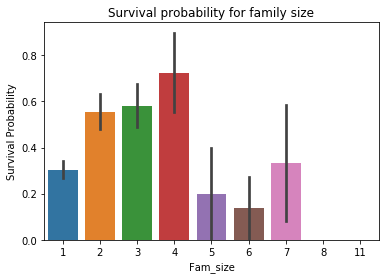

In [31]:
#Family size
fig = sns.barplot(x="Fam_size",y="Survived", data=titanic[0:len(Train)])
fig = fig.set(xlabel="Fam_size", ylabel="Survival Probability")
fig = plt.title("Survival probability for family size")

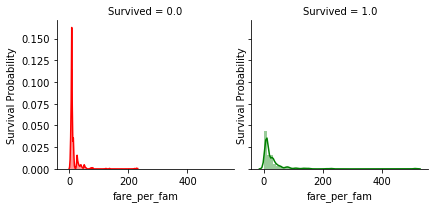

In [32]:
#fare_per_fam 
d = {'color': ['r', 'g']}   
fig = sns.FacetGrid(titanic[0:len(Train)], col='Survived',  hue_kws=d, hue='Survived')
fig = fig.map(sns.distplot, "fare_per_fam")   

fig = fig.set(xlabel="fare_per_fam", ylabel="Survival Probability")



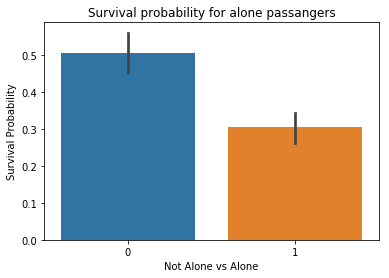

In [33]:
#Alone
fig = sns.barplot(x="Alone",y="Survived", data=titanic[0:len(Train)])
fig = fig.set(xlabel="Not Alone vs Alone", ylabel="Survival Probability")
fig = plt.title("Survival probability for alone passangers")

In [34]:
#Remove Features
exclude_col = ['Name', 'Ticket', 'Survived']
Dropped = titanic[list(set(titanic.columns) - set(exclude_col))]

#Numeric Features
list_num = Dropped.select_dtypes(include = ["number"]).columns



#Catagorical Features (to be transformed into OHE)
list_cat = Dropped.select_dtypes(include = ["object"]).columns
list_cat

Index(['Title', 'Cabin', 'Fam_ID', 'Sex', 'Embarked'], dtype='object')

In [35]:
class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        return(self)
    
    def transform(self, X):
        return X[self.feature_names]#.values
    
class cat_convert(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        return(self)
    
    def transform(self, X):
        df = X[self.feature_names] 
        
        #Convert cabin code to numeric (single col)
        #df["Cabin"] = df.loc[:,"Cabin"].replace(
        #        {'A':1, 'B':2, 'C':3, 'D':4, 'E':5,
        #         'F':6, 'G':7, 'T':8, 'U':0})
        
        #Convert cabin code to numeric (OHE)
        for i in ('A','B','C','D','E','F','G','T','U'):
            df[i] = 0
            df[i].loc[(df["Cabin"] == i)] = 1
                      
        
        #Convert family ID to numeric
        df["Fam_ID"] = pd.factorize(df["Fam_ID"])[0]
        
        #Convert Sex to numeric
        #df["Sex"] = df.loc[:,"Sex"].replace(
        #        {'male':0, 'female':1})
        
        #Convert sex to numeric (OHE)
        for i in ('male','female'):
            df[i] = 0
            df[i].loc[df["Sex"] == i] = 1
        
        
        #Convert honorifics to numeric
        #df["Title"] = df.loc[:,"Title"].replace(
        #    {'Rare':0, 'Women/Girls':1, 
        #     'Boys':2, 'Men':3})
        
        #Convert honorifics to numeric (OHE)
        for i in ('Rare','Women/Girls','Boys','Men'):
            df[i] = 0
            df[i].loc[df["Title"] == i] = 1
        
        #Convert Embarked locations to numeric 
        #df["Embarked"] = df.loc[:,"Embarked"].replace(
        #    {'S':1, 'C':2, 'Q':3})
        
        #Convert Embarked locations to numeric (OHE)
        for i in ('S','C','Q'):
            df[i] = 0
            df[i].loc[df["Embarked"] == i] = 1
            
        #If using OHE:
        df.drop(labels=["Cabin", "Sex", "Title", "Embarked"], axis = 1, inplace = True)
        
        
        return df    
    


In [36]:
#Catagorical Transformations
#cat_pipeline = Pipeline([
#    ('cat_convert', cat_convert(list_cat))
#])


#Numeric Transformations
#num_pipeline = Pipeline([
#    ('selector', Selector(list_num)),
#    ('imputer', SimpleImputer(strategy="median")),
#    ('std_scaler', StandardScaler())
#])

#perpare_pipeline = FeatureUnion(transformer_list=[
#    ("cat_convert", cat_convert),
#    ("num_pipeline", num_pipeline)
#])

#full_pipe = Pipeline([
#    ("add_pipeline", add_pipeline),
#    ("prep_pipeline", perpare_pipeline)
#])

In [37]:
#Catagorical Transformations
cat_pipeline_num = Pipeline([
    ('cat_convert_num', cat_convert(list_cat))
])


#Numeric Transformations
num_pipeline = Pipeline([
    ('selector', Selector(list_num)),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

perpare_pipeline = FeatureUnion(transformer_list=[
    ("cat_pipeline_num", cat_pipeline_num),
    ("num_pipeline", num_pipeline)
])

full_pipe = Pipeline([
    ("add_pipeline", add_pipeline),
    ("prep_pipeline", perpare_pipeline)
])

In [38]:
#titanic.info()
train_test = full_pipe.fit_transform(full_data)
train_test.shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_

(1309, 31)

In [39]:
#Transformed datasets
train_test = full_pipe.fit_transform(full_data)

y_train = Train["Survived"].copy()
X_train = train_test[0:len(Train)]
X_test = train_test[len(Train):len(Train)+len(Test)]

print("Before Transformations:")
print("Full Shape: {}\n".format(full_data.shape))
print("After Transformations:")
print("Train Shape: {}".format(X_train.shape))
print("Test Shape: {}".format(X_test.shape))

notify("Python: Kaggle", "Transformations are complete")

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

Before Transformations:
Full Shape: (1309, 12)

After Transformations:
Train Shape: (891, 31)
Test Shape: (418, 31)


In [40]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, ver_index in split.split(Train, Train["Survived"]):
    Train_strat = Train.loc[train_index]
    Ver_strat = Train.loc[ver_index]

print("Training set: {} entries, Verificaiton set: {} entries".format(len(Train_strat),len(Ver_strat)))

Training set: 712 entries, Verificaiton set: 179 entries


In [41]:
#Split Train dataset into training and verification:
y_training = Train_strat["Survived"].copy()
X_training = full_pipe.fit_transform(Train_strat)

y_verification = Ver_strat["Survived"].copy()
X_verification = full_pipe.fit_transform(Ver_strat)

print("Training Shape: {} entries\nVerificaiton Shape: {} entries".format(X_training.shape,X_verification.shape))

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

Training Shape: (712, 31) entries
Verificaiton Shape: (179, 31) entries


In [42]:
#To create new model if pickle already even if pickle exists; load_pkl = False
load_pkl = True

cv_split=StratifiedKFold(n_splits=10)
cv_split

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [43]:
def model_cross_val(clf, name_clf, x_tr, y_tr, lp=load_pickle):
    if pickle_exist(str(name_clf)) and (lp==True):
        ml_clf = load_pickle(str(name_clf))
    else:
        ml_clf = clf
        ml_clf.fit(x_tr, y_tr)
        save_pickle(str(name_clf), ml_clf)
    cvs =  cross_val_score(ml_clf, x_tr, y_tr, cv=cv_split, scoring="accuracy") 
    return  np.mean(cvs)


In [44]:
clf_options = [          
    LinearSVC(), #no proba
    SVC(probability=True),
    NuSVC(probability=True),
    
    LogisticRegression(),
    SGDClassifier(),
    PassiveAggressiveClassifier(), #no proba
    Perceptron(), #no proba
    RidgeClassifier(), #no proba
    
    GaussianProcessClassifier(),
    
    BernoulliNB(),
    GaussianNB(),
    
    DecisionTreeClassifier(),
    
    KNeighborsClassifier(),
    
    
    RandomForestClassifier(),
    AdaBoostClassifier(DecisionTreeClassifier(),
                       learning_rate=0.1),
    
    ExtraTreesClassifier(),
    GradientBoostingClassifier(),
    BaggingClassifier(),
    
    LinearDiscriminantAnalysis(),

    MLPClassifier()
] 
 

   
compare_col = ['Clf Name', 'Clf Parameters', 'Clf Train Accuracy', 'Clf Verification Accuracy'] 
clf_compare = pd.DataFrame(columns = compare_col)
                 
row=0
          
for clf in clf_options: 
    clf_name = clf.__class__.__name__
                    
    clf_compare.loc[row, 'Clf Name'] = clf_name
    clf_compare.loc[row, 'Clf Parameters'] = str(clf.get_params()) 
    cvs = model_cross_val(clf, clf_name, X_training, y_training)
    
    clf_compare.loc[row, 'Clf Train Accuracy'] = cvs
    
    clf.fit(X_training, y_training)
    y_pred = clf.predict(X_verification)
    ver_acc = accuracy_score(y_verification, y_pred)
    
    clf_compare.loc[row, 'Clf Verification Accuracy'] = ver_acc
    
    
    row +=1

               

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved LinearSVC successfully!



/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved SVC successfully!



/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved NuSVC successfully!



/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved LogisticRegression successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved SGDClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved PassiveAggressiveClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved Perceptron successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Saving model...
Saved RidgeClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved GaussianProcessClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved BernoulliNB successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved GaussianNB successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved DecisionTreeClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved KNeighborsClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved RandomForestClassifier successfully!



/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved AdaBoostClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved ExtraTreesClassifier successfully!



/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved GradientBoostingClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved BaggingClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved LinearDiscriminantAnalysis successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn

Saving model...
Saved MLPClassifier successfully!



/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/ana

In [45]:
clf_compare.sort_values(by = 'Clf Verification Accuracy', ascending = False, inplace = True)
clf_compare


,Clf Name,Clf Parameters,Clf Train Accuracy,Clf Verification Accuracy
11,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.96913,0.994413
14,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__clas...",0.971947,0.994413
19,MLPClassifier,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",0.97897,0.988827
3,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.980359,0.972067
16,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.974745,0.972067
5,PassiveAggressiveClassifier,"{'C': 1.0, 'average': False, 'class_weight': N...",0.935523,0.972067
17,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.970539,0.96648
0,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.980339,0.96648
7,RidgeClassifier,"{'alpha': 1.0, 'class_weight': None, 'copy_X':...",0.974685,0.960894
18,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.976094,0.960894


In [46]:
#Parameters of classifiers (Random Search):

#Linear SVC
lin_svc_rs = {
    'loss' : ['hinge','squared_hinge'],
    'C' : reciprocal(0.01, 1000)
}


#SVC
svc_rs = {
    'C' : reciprocal(0.01, 10000),
    'kernel' : ['linear', 'rbf'],
    'gamma' : reciprocal(0.01, 10000)
}

#NuSVC
nuSVC_rs = {
    'kernel' : ['linear', 'rbf'],
    'gamma' : reciprocal(0.01, 10000)
}



#Logistic Regression
log_reg_rs = {
    'penalty' : ['l1', 'l2'],
    'C' : reciprocal(0.01, 1000) 
}

#SGDClassifier
SGDC_rs = {
    'loss' : ['hinge','squared_hinge', 'perceptron'],
    'penalty' : ['l1', 'l2'],
    'alpha': reciprocal(0.1, 10000), 
    'warm_start' : [True, False]
}




#PassiveAggressiveClassifier
pass_rs = {
    'C' : reciprocal(0.01, 1000),
    'fit_intercept' : [True, False]
}


#Perceptron
perc_rs = {
    'alpha': reciprocal(0.1, 10000), 
    'fit_intercept' : [True, False],
    'shuffle' : [True, False],
    'warm_start' : [True, False]
}


#RidgeClassifier
ridge_rs = {
    'alpha': reciprocal(0.1, 10000)
}

#GaussianProcessClassifier
gaus_rs = {
    'warm_start' : [True, False]
}

    
#BernoulliNB
bernNB_rs = {
    'alpha': reciprocal(0.1, 10000),
    'binarize': reciprocal(0.1, 10000),
    'fit_prior' : [True, False]
    
}


#GaussianNB
guasNB_rs = {
    'var_smoothing': reciprocal(1, 1000000),
}

#Decision Tree Classifier
tree_rs = {
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
    'max_depth' : randint(1, 5),
    'min_samples_split' : randint(2, 10),
    'min_samples_leaf' : randint(1, 10),
    'max_features' : randint(1, 10)
}

  
#K-Neighbors Classifier
k_neigh_rs = {
    'n_neighbors': randint(3, 15),
    'weights' : ['uniform','distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : randint(2, 100),
    'p' : randint(1, 2)
}

#Random Forest Classifier
forest_rs = {
    'n_estimators' : randint(10, 500),
    'criterion' : ['gini', 'entropy'],
    'max_depth' : randint(1, 5),
    'min_samples_split' : randint(2, 15),
    'min_samples_leaf' : randint(1, 15),
    'max_features' : randint(1, 15)
}
    
#AdaBoost Classifier
ada_rs = {
    'base_estimator__criterion' : ['gini', 'entropy'],
    'base_estimator__splitter' : ['best', 'random'],
    'n_estimators' : randint(1, 50),
    'learning_rate' : reciprocal(0.6, 10000),
    'algorithm' : ['SAMME', 'SAMME.R']
    
}


#Extra Trees Classifier
extra_tree_rs = {
    'n_estimators' : randint(10, 500),
    'criterion' : ['gini', 'entropy'],
    'min_samples_split' : randint(2, 10),
    'min_samples_leaf' : randint(1, 10),
    'max_features' : randint(1, 10)    
    
}


#Gradient Boosting Classifier
grad_boost_rs = {
    'loss' : ['deviance', 'exponential'],
    'learning_rate' : reciprocal(0.6, 10000),
    'n_estimators' : randint(10, 500),
    'min_samples_split' : randint(2, 15),
    'min_samples_leaf' : randint(1, 15),
    'max_depth': randint(3, 15),
    'max_features' : randint(1, 15)
    
}  


bag_rs = {
    'n_estimators' : randint(10, 50)
}

#LinearDiscriminantAnalysis
linDes_rs = {
    'solver' : ['svd']
}


#MLPClassifier
MLPC_rs = {
    'hidden_layer_sizes' : randint(10, 1000),
    'alpha': reciprocal(0.1, 10000),
    'warm_start' : [True, False]
}



param_option_rs = [
    lin_svc_rs,
    svc_rs,
    nuSVC_rs,
    log_reg_rs,
    SGDC_rs,
    pass_rs,
    perc_rs,
    ridge_rs,
    gaus_rs,
    bernNB_rs,
    guasNB_rs,
    tree_rs,
    k_neigh_rs,
    forest_rs,
    ada_rs,
    extra_tree_rs,
    grad_boost_rs, 
    bag_rs,
    linDes_rs,
    MLPC_rs  
    
]


In [47]:
def model_rand_gs(clf, name_clf, clf_param, x_tr, y_tr, lp=load_pickle): 

    rand_clf = RandomizedSearchCV(clf, param_distributions=clf_param, cv=cv_split, 
                          verbose=2, n_jobs=-1, n_iter=50, scoring='accuracy')
    
    rand_clf.fit(x_tr, y_tr)
    
    best_est = rand_clf.best_estimator_
    best_sco = rand_clf.best_score_ 
    
    text_check = os.path.isfile(PICKLE_PATH+"/best_score_rs_"+str(name_clf)+".txt")
    
    if pickle_exist("best_rs_"+str(name_clf)) and text_check and (lp==True):
        #load current best score
        prev_best_score = max(np.loadtxt(
            (PICKLE_PATH+"/best_score_rs_"+str(name_clf)+".txt"), dtype=float))

        if best_sco > prev_best_score:
            temp = [best_sco, best_sco]
            np.savetxt(
                PICKLE_PATH+"/best_score_rs_"+str(name_clf)+".txt", temp, fmt='%f')
            save_pickle("best_rs_"+str(name_clf), best_est)
        else:
            #load in better parameters
            best_sco = max(np.loadtxt(
                PICKLE_PATH+"/best_score_rs_"+str(name_clf)+".txt", dtype=float))
            best_est = load_pickle("best_rs_"+str(name_clf))
    else:
        #make pickles if dont exist
        temp = [best_sco, best_sco]
        np.savetxt(
            PICKLE_PATH+"/best_score_rs_"+str(name_clf)+".txt", temp, fmt='%f')
        save_pickle("best_rs_"+str(name_clf), best_est)


In [48]:
best_col = ['Clf Name', 'Best Clf Parameters', 'Best Clf Training Score', 'Best Clf Verification Score'] 
best_compare_rs = pd.DataFrame(columns = best_col)
          
          
row=0

for clf, param in zip(clf_options, param_option_rs): 
    
    clf_name = clf.__class__.__name__
    best_compare_rs.loc[row, 'Clf Name'] = clf_name
    
    print("{}: {}".format(row, clf_name))
    
    model_rand_gs(clf, clf_name, param, X_training, y_training)
   
    
    best_score = max(np.loadtxt((PICKLE_PATH+"/best_score_rs_"+str(clf_name)+".txt"), dtype=float))
    best_clf = load_pickle("best_rs_"+str(clf_name))
    
    print("{}: {}\n".format(clf_name, best_clf.get_params))
        
    best_compare_rs.loc[row, 'Best Clf Parameters'] = str(best_clf.get_params())
    best_compare_rs.loc[row, 'Best Clf Training Score'] = str(best_score)
    
    best_clf.fit(X_training, y_training)
    y_pred = best_clf.predict(X_verification)
    ver_acc = accuracy_score(y_verification, y_pred)
    
    best_compare_rs.loc[row, 'Best Clf Verification Score'] = ver_acc
    
    row +=1
                    

0: LinearSVC
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 485 out of 500 | elapsed:    4.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.5s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_LinearSVC successfully!

Loading best_rs_LinearSVC from Pickle file...
best_rs_LinearSVC successfully loaded!

LinearSVC: <bound method BaseEstimator.get_params of LinearSVC(C=7.161618212919516, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)>

1: SVC
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.1min finished


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_SVC successfully!

Loading best_rs_SVC from Pickle file...
best_rs_SVC successfully loaded!

SVC: <bound method BaseEstimator.get_params of SVC(C=0.22049897105690705, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.11230667352642584,
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)>

2: NuSVC
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.4s finished


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_NuSVC successfully!

Loading best_rs_NuSVC from Pickle file...
best_rs_NuSVC successfully loaded!

NuSVC: <bound method BaseEstimator.get_params of NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma=620.9624296070956,
   kernel='linear', max_iter=-1, nu=0.5, probability=True,
   random_state=None, shrinking=True, tol=0.001, verbose=False)>

3: LogisticRegression
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.6s finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_LogisticRegression successfully!

Loading best_rs_LogisticRegression from Pickle file...
best_rs_LogisticRegression successfully loaded!

LogisticRegression: <bound method BaseEstimator.get_params of LogisticRegression(C=0.6542389095361913, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)>

4: SGDClassifier
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are l

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_SGDClassifier successfully!

Loading best_rs_SGDClassifier from Pickle file...
best_rs_SGDClassifier successfully loaded!

SGDClassifier: <bound method BaseEstimator.get_params of SGDClassifier(alpha=0.14519145168812825, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='squared_hinge',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=True)>

5: PassiveAggressiveClassifier
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_ite

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_PassiveAggressiveClassifier successfully!

Loading best_rs_PassiveAggressiveClassifier from Pickle file...
best_rs_PassiveAggressiveClassifier successfully loaded!

PassiveAggressiveClassifier: <bound method BaseEstimator.get_params of PassiveAggressiveClassifier(C=20.74708142541258, average=False,
              class_weight=None, early_stopping=False, fit_intercept=False,
              loss='hinge', max_iter=None, n_iter=None, n_iter_no_change=5,
              n_jobs=None, random_state=None, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)>

6: Perceptron
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not No

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_Perceptron successfully!

Loading best_rs_Perceptron from Pickle file...
best_rs_Perceptron successfully loaded!

Perceptron: <bound method BaseEstimator.get_params of Perceptron(alpha=4.110883656140692, class_weight=None, early_stopping=False,
      eta0=1.0, fit_intercept=True, max_iter=None, n_iter=None,
      n_iter_no_change=5, n_jobs=None, penalty=None, random_state=0,
      shuffle=True, tol=None, validation_fraction=0.1, verbose=0,
      warm_start=True)>

7: RidgeClassifier
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 2 is smaller than n_iter=50. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_RidgeClassifier successfully!

Loading best_rs_RidgeClassifier from Pickle file...
best_rs_RidgeClassifier successfully loaded!

RidgeClassifier: <bound method BaseEstimator.get_params of RidgeClassifier(alpha=0.20834904311907254, class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='auto', tol=0.001)>

8: GaussianProcessClassifier
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    3.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.9s finished


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_GaussianProcessClassifier successfully!

Loading best_rs_GaussianProcessClassifier from Pickle file...
best_rs_GaussianProcessClassifier successfully loaded!

GaussianProcessClassifier: <bound method BaseEstimator.get_params of GaussianProcessClassifier(copy_X_train=True, kernel=None,
             max_iter_predict=100, multi_class='one_vs_rest', n_jobs=None,
             n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
             random_state=None, warm_start=True)>

9: BernoulliNB
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_BernoulliNB successfully!

Loading best_rs_BernoulliNB from Pickle file...
best_rs_BernoulliNB successfully loaded!

BernoulliNB: <bound method BaseEstimator.get_params of BernoulliNB(alpha=39.157444857093026, binarize=0.11904012056106883,
      class_prior=None, fit_prior=False)>

10: GaussianNB
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_GaussianNB successfully!

Loading best_rs_GaussianNB from Pickle file...
best_rs_GaussianNB successfully loaded!

GaussianNB: <bound method BaseEstimator.get_params of GaussianNB(priors=None, var_smoothing=1.3639453397845644)>

11: DecisionTreeClassifier
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_DecisionTreeClassifier successfully!

Loading best_rs_DecisionTreeClassifier from Pickle file...
best_rs_DecisionTreeClassifier successfully loaded!

DecisionTreeClassifier: <bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=7,
            min_samples_split=9, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')>

12: KNeighborsClassifier
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_KNeighborsClassifier successfully!

Loading best_rs_KNeighborsClassifier from Pickle file...
best_rs_KNeighborsClassifier successfully loaded!

KNeighborsClassifier: <bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='ball_tree', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=1,
           weights='distance')>

13: RandomForestClassifier
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   47.6s finished


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_RandomForestClassifier successfully!

Loading best_rs_RandomForestClassifier from Pickle file...
best_rs_RandomForestClassifier successfully loaded!

RandomForestClassifier: <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features=7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=7, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=251, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

14: AdaBoostClassifier
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_AdaBoostClassifier successfully!

Loading best_rs_AdaBoostClassifier from Pickle file...
best_rs_AdaBoostClassifier successfully loaded!

AdaBoostClassifier: <bound method BaseEstimator.get_params of AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random'),
          learning_rate=8.030706300184457, n_estimators=47,
          random_state=None)>

15: ExtraTreesClassifier
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 307 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   43.5s finished


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_ExtraTreesClassifier successfully!

Loading best_rs_ExtraTreesClassifier from Pickle file...
best_rs_ExtraTreesClassifier successfully loaded!

ExtraTreesClassifier: <bound method BaseEstimator.get_params of ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features=6, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=9,
           min_weight_fraction_leaf=0.0, n_estimators=302, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)>

16: GradientBoostingClassifier
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   41.1s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_GradientBoostingClassifier successfully!

Loading best_rs_GradientBoostingClassifier from Pickle file...
best_rs_GradientBoostingClassifier successfully loaded!

GradientBoostingClassifier: <bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.7481263371579097, loss='deviance',
              max_depth=12, max_features=11, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=8, min_samples_split=14,
              min_weight_fraction_leaf=0.0, n_estimators=414,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)>

17: BaggingClassifier
Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.3s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_BaggingClassifier successfully!

Loading best_rs_BaggingClassifier from Pickle file...
best_rs_BaggingClassifier successfully loaded!

BaggingClassifier: <bound method BaseEstimator.get_params of BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)>

18: LinearDiscriminantAnalysis
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_LinearDiscriminantAnalysis successfully!

Loading best_rs_LinearDiscriminantAnalysis from Pickle file...
best_rs_LinearDiscriminantAnalysis successfully loaded!

LinearDiscriminantAnalysis: <bound method BaseEstimator.get_params of LinearDiscrimi

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.9min finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_MLPClassifier successfully!

Loading best_rs_MLPClassifier from Pickle file...
best_rs_MLPClassifier successfully loaded!

MLPClassifier: <bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.6208160081202799, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=980, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=True)>



In [49]:
#Random Grid-search
best_compare_rs.sort_values(by = 'Best Clf Verification Score', ascending = False, inplace = True)

notify("Python: Kaggle", "Random Search is complete")
best_compare_rs


,Clf Name,Best Clf Parameters,Best Clf Training Score,Best Clf Verification Score
13,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.980337,0.994413
5,PassiveAggressiveClassifier,"{'C': 20.74708142541258, 'average': False, 'cl...",0.969101,0.977654
14,AdaBoostClassifier,"{'algorithm': 'SAMME', 'base_estimator__class_...",0.98736,0.977654
11,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.939607,0.977654
17,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.980337,0.972067
1,SVC,"{'C': 0.22049897105690705, 'cache_size': 200, ...",0.983146,0.972067
3,LogisticRegression,"{'C': 0.6542389095361913, 'class_weight': None...",0.983146,0.96648
16,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.977528,0.96648
15,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.974719,0.96648
0,LinearSVC,"{'C': 7.161618212919516, 'class_weight': None,...",0.984551,0.960894


In [50]:
#Parameters of classifiers (Grid Search):

#Linear SVC
lin_svc_param = {
    'loss' : ['hinge','squared_hinge'],
    'C' : [1, 2, 5, 10]
}


#SVC
svc_param = {
    'C' : [0.0001, 0.001, 0.1, 1, 10, 50, 100],
    'kernel' : ['linear', 'rbf'],
    'gamma' : [0.0001, 0.001, 0.1, 1, 10, 50, 100]
}

#NuSVC
nuSVC_param = {
    'kernel' : ['linear', 'rbf'],
    'gamma' : [ 0.001, 0.01, 0.1, 1]
}

#Logistic Regression
log_reg_param = {
    'penalty' : ['l1', 'l2'],
    'C': [1, 2, 5, 10]
}

#SGDClassifier
SGDC_param = {
    'loss' : ['hinge','squared_hinge', 'perceptron'],
    'penalty' : ['l1', 'l2'],
    'alpha' : [0.001, 0.01, 0.1, 1],
    'warm_start' : [True, False]
}


#PassiveAggressiveClassifier
pass_param = {
    'C' : [1, 2, 5, 10],
    'fit_intercept' : [True, False]
}


#Perceptron
perc_param = {
    'alpha': [0.001, 0.01, 0.1, 1], 
    'fit_intercept' : [True, False],
    'shuffle' : [True, False],
    'warm_start' : [True, False]
}


#RidgeClassifier
ridge_param = {
    'alpha': [0.001, 0.01, 0.1, 1]
}

#GaussianProcessClassifier
gaus_param = {
    'warm_start' : [True, False]
}

    
#BernoulliNB
bernNB_param = {
    'alpha': [0.001, 0.01, 0.1, 1],
    'binarize': [0.001, 0.01, 0.1, 1],
    'fit_prior' : [True, False]
    
}


#GaussianNB
guasNB_param = {
    'var_smoothing': [0.001, 0.01, 0.1, 1],
}


#Decision Tree Classifier
tree_param = {
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
    'max_depth' : [1, 2, 3, 5],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 3, 10],
    'max_features' : [1, 5, 10]
}

#K-Neighbors Classifier
k_neigh_param = {
    'n_neighbors': [3, 4, 5, 10],
    'weights' : ['uniform','distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [2, 10, 50, 100],
    'p' : [1, 2]
}


#Random Forest Classifier
forest_param = {
    'n_estimators' : [10, 50, 100, 200],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [1, 2, 5, 9, 10],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 3, 10],
    'max_features' : [0.5, 1, 5, 10]
}

#AdaBoost Classifier
ada_param = {
    'base_estimator__criterion' : ['gini', 'entropy'],
    'base_estimator__splitter' : ['best', 'random'],
    'n_estimators' : [1, 2, 5, 10, 50],
    'learning_rate' : [0.001, 0.01, 0.1, 0.5, 1],
    'algorithm' : ['SAMME', 'SAMME.R']
    
}

#Extra Trees Classifier
extra_tree_param = {
    'n_estimators' : [100, 200, 300, 500],
    'criterion' : ['gini', 'entropy'],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 5,10],
    'max_features' : [1, 5, 10]    
    
}

#Gradient Boosting Classifier
grad_boost_param = {
    'loss' : ['deviance', 'exponential'],
    'learning_rate' : [0.01, 0.1, 1],
    'n_estimators' : [100, 200],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 10, 100],
    'max_depth': [3, 5, 10],
    'max_features': [0.1, 0.3]
    
}   

#Bagging Classifier
bag_param = {
    'n_estimators' : [10, 20, 50, 100, 200, 500],
}

#LinearDiscriminantAnalysis
linDes_param = {
    'solver' : ['svd']
}


#MLPClassifier
MLPC_param = {
    'hidden_layer_sizes' : [10, 50, 100, 500, 1000],
    'alpha': [0.001, 0.01, 0.1, 1],
    'warm_start' : [True, False]
}
               
                
param_option_gs = [
    lin_svc_param, 
    svc_param, 
    nuSVC_param, 
    log_reg_param, 
    SGDC_param, 
    pass_param, 
    perc_param, 
    ridge_param, 
    gaus_param,
    bernNB_param,
    guasNB_param,
    tree_param,
    k_neigh_param,
    forest_param,
    ada_param,
    extra_tree_param,
    grad_boost_param,
    bag_param,
    linDes_param,
    MLPC_param
]



In [51]:

def model_grid(clf, name_clf, clf_param, x_tr, y_tr, lp=load_pickle): 

    gs_clf = GridSearchCV(clf, param_grid=clf_param, cv=cv_split, 
                          verbose=2, n_jobs=-1, scoring='accuracy')
    
    gs_clf.fit(x_tr, y_tr)
    
    best_est = gs_clf.best_estimator_
    best_sco = gs_clf.best_score_ 
    
    text_check = os.path.isfile(PICKLE_PATH+"/best_score_gs_"+str(name_clf)+".txt")
    
    if pickle_exist("best_gs_"+str(name_clf)) and text_check and (lp==True):
        #load current best score
        prev_best_score = max(np.loadtxt((PICKLE_PATH+"/best_score_gs_"+str(name_clf)+".txt"), dtype=float))

        if best_sco > prev_best_score:
            temp = [best_sco, best_sco]
            np.savetxt(PICKLE_PATH+"/best_score_gs_"+str(name_clf)+".txt", temp, fmt='%f')
            save_pickle("best_gs_"+str(name_clf), best_est)
        else:
            #load in better parameters
            best_sco = max(np.loadtxt(PICKLE_PATH+"/best_score_gs_"+str(name_clf)+".txt", dtype=float))
            best_est = load_pickle("best_gs_"+str(name_clf))
    else:
        #make pickles if dont exist
        temp = [best_sco, best_sco]
        np.savetxt(PICKLE_PATH+"/best_score_gs_"+str(name_clf)+".txt", temp, fmt='%f')
        save_pickle("best_gs_"+str(name_clf), best_est)

    
    

In [52]:
best_col = ['Clf Name', 'Best Clf Parameters', 
            'Best Clf Accuracy Score', 'Best Clf Verification Score'] 

best_compare_gs = pd.DataFrame(columns = best_col)
          
          
row=0

for clf, param in zip(clf_options, param_option_gs): 

    
    clf_name = clf.__class__.__name__
    best_compare_gs.loc[row, 'Clf Name'] = clf_name
    
    print("{}: {}".format(row, clf_name))
    
    model_grid(clf, clf_name, param, X_training, y_training)
    
    best_score = max(np.loadtxt((PICKLE_PATH+"/best_score_gs_"+str(clf_name)+".txt"), dtype=float))
    best_clf = load_pickle("best_gs_"+str(clf_name))
    
    best_compare_gs.loc[row, 'Best Clf Parameters'] = str(best_clf.get_params())
    best_compare_gs.loc[row, 'Best Clf Accuracy Score'] = str(best_score)
    
    best_clf.fit(X_training, y_training)
    y_pred = best_clf.predict(X_verification)
    ver_acc = accuracy_score(y_verification, y_pred)
    
    best_compare_gs.loc[row, 'Best Clf Verification Score'] = ver_acc
    
    row +=1

0: LinearSVC
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  80 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.5s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_gs_LinearSVC successfully!

Loading best_gs_LinearSVC from Pickle file...
best_gs_LinearSVC successfully loaded!

1: SVC
Fitting 10 folds for each of 98 candidates, totalling 980 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 573 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 856 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 980 out of 980 | elapsed:  4.2min finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_gs_SVC successfully!

Loading best_gs_SVC from Pickle file...
best_gs_SVC successfully loaded!

2: NuSVC
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.4s finished


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_gs_NuSVC successfully!

Loading best_gs_NuSVC from Pickle file...
best_gs_NuSVC successfully loaded!

3: LogisticRegression
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.3s finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_gs_LogisticRegression successfully!

Loading best_gs_LogisticRegression from Pickle file...
best_gs_LogisticRegression successfully loaded!

4: SGDClassifier
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    0.7s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is 

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_gs_SGDClassifier successfully!

Loading best_gs_SGDClassifier from Pickle file...
best_gs_SGDClassifier successfully loaded!

5: PassiveAggressiveClassifier
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.2s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_ite

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_gs_PassiveAggressiveClassifier successfully!

Loading best_gs_PassiveAggressiveClassifier from Pickle file...
best_gs_PassiveAggressiveClassifier successfully loaded!

6: Perceptron
Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    0.4s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not No

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_gs_Perceptron successfully!

Loading best_gs_Perceptron from Pickle file...
best_gs_Perceptron successfully loaded!

7: RidgeClassifier
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_gs_RidgeClassifier successfully!

Loading best_gs_RidgeClassifier from Pickle file...
best_gs_RidgeClassifier successfully loaded!

8: GaussianProcessClassifier
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    3.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.6s finished


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_gs_GaussianProcessClassifier successfully!

Loading best_gs_GaussianProcessClassifier from Pickle file...
best_gs_GaussianProcessClassifier successfully loaded!

9: BernoulliNB
Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  40 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.2s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_gs_BernoulliNB successfully!

Loading best_gs_BernoulliNB from Pickle file...
best_gs_BernoulliNB successfully loaded!

10: GaussianNB
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_gs_GaussianNB successfully!

Loading best_gs_GaussianNB from Pickle file...
best_gs_GaussianNB successfully loaded!

11: DecisionTreeClassifier
Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:    4.2s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_gs_DecisionTreeClassifier successfully!

Loading best_gs_DecisionTreeClassifier from Pickle file...
best_gs_DecisionTreeClassifier successfully loaded!

12: KNeighborsClassifier
Fitting 10 folds for each of 256 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed:   12.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_gs_KNeighborsClassifier successfully!

Loading best_gs_KNeighborsClassifier from Pickle file...
best_gs_KNeighborsClassifier successfully loaded!

13: RandomForestClassifier
Fitting 10 folds for each of 1440 candidates, totalling 14400 fits


[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 886 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 1452 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 2182 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3072 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4126 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 5340 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 6718 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 8256 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 9958 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 11820 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 13846 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 14400 out of 14400 | elapsed:  8.2min finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The defa

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_gs_RandomForestClassifier successfully!

Loading best_gs_RandomForestClassifier from Pickle file...
best_gs_RandomForestClassifier successfully loaded!

14: AdaBoostClassifier
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_gs_AdaBoostClassifier successfully!

Loading best_gs_AdaBoostClassifier from Pickle file...
best_gs_AdaBoostClassifier successfully loaded!

15: ExtraTreesClassifier
Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  3.7min finished


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_gs_ExtraTreesClassifier successfully!

Loading best_gs_ExtraTreesClassifier from Pickle file...
best_gs_ExtraTreesClassifier successfully loaded!

16: GradientBoostingClassifier
Fitting 10 folds for each of 648 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 547 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 830 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 1195 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2167 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2774 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3463 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 4232 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 5083 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 6014 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:  6.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_gs_GradientBoostingClassifier successfully!

Loading best_gs_GradientBoostingClassifier from Pickle file...
best_gs_GradientBoostingClassifier successfully loaded!

17: BaggingClassifier
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  14 out of  60 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_gs_BaggingClassifier successfully!

Loading best_gs_BaggingClassifier from Pickle file...
best_gs_BaggingClassifier successfully loaded!

18: LinearDiscriminantAnalysis
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_gs_LinearDiscriminantAnalysis successfully!

Loading best_gs_LinearDiscriminantAnalysis from Pickle file...
best_gs_LinearDiscriminantAnalysis successfully loaded!

19: MLPClassifier
Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.3min finished


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_gs_MLPClassifier successfully!

Loading best_gs_MLPClassifier from Pickle file...
best_gs_MLPClassifier successfully loaded!



/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [53]:
#After Gridseach
best_compare_gs.sort_values(by = 'Best Clf Accuracy Score', ascending = False, inplace = True)

notify("Python: Kaggle", "Grid Search is complete")
best_compare_gs

,Clf Name,Best Clf Parameters,Best Clf Accuracy Score,Best Clf Verification Score
13,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.984551,0.972067
3,LogisticRegression,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.983146,0.960894
14,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__clas...",0.983146,0.843575
19,MLPClassifier,"{'activation': 'relu', 'alpha': 1, 'batch_size...",0.981742,0.977654
16,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.981742,0.960894
17,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.980337,0.96648
15,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.978933,0.977654
0,LinearSVC,"{'C': 2, 'class_weight': None, 'dual': True, '...",0.978933,0.977654
1,SVC,"{'C': 0.1, 'cache_size': 200, 'class_weight': ...",0.977528,0.977654
7,RidgeClassifier,"{'alpha': 0.001, 'class_weight': None, 'copy_X...",0.976124,0.960894


In [54]:
def load_best_clf(clf):
    clf_name = clf.__class__.__name__
    
    gs_score = max(np.loadtxt((PICKLE_PATH+"/best_score_gs_"+str(clf_name)+".txt"), dtype=float))
    rs_score = max(np.loadtxt((PICKLE_PATH+"/best_score_rs_"+str(clf_name)+".txt"), dtype=float))
    
    if gs_score > rs_score:
        return load_pickle("best_gs_"+str(clf_name))
    else:
        return load_pickle("best_rs_"+str(clf_name))

    
    
def load_best_score(clf):
    clf_name = clf.__class__.__name__
    
    gs_score = max(np.loadtxt((PICKLE_PATH+"/best_score_gs_"+str(clf_name)+".txt"), dtype=float))
    rs_score = max(np.loadtxt((PICKLE_PATH+"/best_score_rs_"+str(clf_name)+".txt"), dtype=float))
    
    if gs_score > rs_score:
        return gs_score
    else:
        return rs_score

In [55]:
best_col = ['Clf Name', 'Best Clf Parameters', 'Best Clf Training Score', 'Best Clf Verification Score'] 
best_rs_or_gs = pd.DataFrame(columns = best_col)
row=0

for clf in clf_options:
    clf_name = clf.__class__.__name__
    best_rs_or_gs.loc[row, 'Clf Name'] = clf_name
    
    best_clf  = load_best_clf(clf)
    best_score = load_best_score(clf)
    
    best_rs_or_gs.loc[row, 'Best Clf Parameters'] = str(best_clf.get_params())
    best_rs_or_gs.loc[row, 'Best Clf Training Score'] = str(best_score)
    
    clf.fit(X_training, y_training)
    y_pred = clf.predict(X_verification)
    ver_acc = accuracy_score(y_verification, y_pred)
    
    best_rs_or_gs.loc[row, 'Best Clf Verification Score'] = ver_acc
    
    
    row +=1
    
best_rs_or_gs.sort_values(by = 'Best Clf Verification Score', ascending = False, inplace = True)
best_rs_or_gs    

Loading best_rs_LinearSVC from Pickle file...
best_rs_LinearSVC successfully loaded!

Loading best_rs_SVC from Pickle file...
best_rs_SVC successfully loaded!

Loading best_rs_NuSVC from Pickle file...
best_rs_NuSVC successfully loaded!



/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Loading best_rs_LogisticRegression from Pickle file...
best_rs_LogisticRegression successfully loaded!

Loading best_gs_SGDClassifier from Pickle file...
best_gs_SGDClassifier successfully loaded!

Loading best_rs_PassiveAggressiveClassifier from Pickle file...
best_rs_PassiveAggressiveClassifier successfully loaded!

Loading best_rs_Perceptron from Pickle file...
best_rs_Perceptron successfully loaded!

Loading best_rs_RidgeClassifier from Pickle file...
best_rs_RidgeClassifier successfully loaded!

Loading best_rs_GaussianProcessClassifier from Pickle file...
best_rs_GaussianProcessClassifier successfully loaded!



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/pyt

Loading best_gs_BernoulliNB from Pickle file...
best_gs_BernoulliNB successfully loaded!

Loading best_gs_GaussianNB from Pickle file...
best_gs_GaussianNB successfully loaded!

Loading best_gs_DecisionTreeClassifier from Pickle file...
best_gs_DecisionTreeClassifier successfully loaded!

Loading best_rs_KNeighborsClassifier from Pickle file...
best_rs_KNeighborsClassifier successfully loaded!

Loading best_gs_RandomForestClassifier from Pickle file...
best_gs_RandomForestClassifier successfully loaded!

Loading best_rs_AdaBoostClassifier from Pickle file...
best_rs_AdaBoostClassifier successfully loaded!

Loading best_gs_ExtraTreesClassifier from Pickle file...
best_gs_ExtraTreesClassifier successfully loaded!

Loading best_gs_GradientBoostingClassifier from Pickle file...
best_gs_GradientBoostingClassifier successfully loaded!

Loading best_rs_BaggingClassifier from Pickle file...
best_rs_BaggingClassifier successfully loaded!

Loading best_rs_LinearDiscriminantAnalysis from Pickle f

/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,Clf Name,Best Clf Parameters,Best Clf Training Score,Best Clf Verification Score
11,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'entropy',...",0.969101,0.994413
14,AdaBoostClassifier,"{'algorithm': 'SAMME', 'base_estimator__class_...",0.98736,0.994413
0,LinearSVC,"{'C': 7.161618212919516, 'class_weight': None,...",0.984551,0.988827
19,MLPClassifier,"{'activation': 'relu', 'alpha': 1, 'batch_size...",0.981742,0.98324
15,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.978933,0.977654
17,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.980337,0.977654
5,PassiveAggressiveClassifier,"{'C': 20.74708142541258, 'average': False, 'cl...",0.969101,0.972067
3,LogisticRegression,"{'C': 0.6542389095361913, 'class_weight': None...",0.983146,0.972067
13,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.984551,0.972067
16,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.981742,0.972067


In [86]:
hardVote = False
voter = 'soft'



#only probabilities: (ie default soft voting)
svc = load_best_clf(clf_options[1])
nu_svc = load_best_clf(clf_options[2])
log_reg = load_best_clf(clf_options[3])
gaus= load_best_clf(clf_options[8])
bernNB = load_best_clf(clf_options[9])
guasNB = load_best_clf(clf_options[10])
tree = load_best_clf(clf_options[11])
knn = load_best_clf(clf_options[12])
forest = load_best_clf(clf_options[13])
ada = load_best_clf(clf_options[14])
etree = load_best_clf(clf_options[15])
gradb = load_best_clf(clf_options[16])
bag = load_best_clf(clf_options[17])
linDes = load_best_clf(clf_options[18])
MLPC = load_best_clf(clf_options[19])


est = [('svc', svc), ('nu_svc', nu_svc), ('log_reg', log_reg),
       ('gaus', gaus), ('bernNB', bernNB), ('guasNB', guasNB), 
       ('tree', tree), ('knn', knn), ('forest', forest), 
       ('ada', ada), ('etree', etree), ('gradb', gradb), 
       ('bag', bag), ('linDes', linDes), ('MLPC', MLPC)]

if hardVote:
    #hard Voting: add probabilities
    voter = 'hard'
    
    lin_svc = load_best_clf(clf_options[0])
    SGDC = load_best_clf(clf_options[4])
    passC = load_best_clf(clf_options[5])
    perc = load_best_clf(clf_options[6])
    ridge = load_best_clf(clf_options[7])
    
    est_add = [('lin_svc', lin_svc), ('SGDC', SGDC),
               ('passC', passC), ('perc', perc), ('ridge', ridge)]
    
    est.extend(est_add)
    

vote_clf = VotingClassifier(estimators=est, voting=voter)


if hardVote:  
    vote_list = (svc, nu_svc, log_reg, SGDC, gaus, 
                 bernNB, guasNB, tree, knn, forest, 
                 ada, etree, gradb, bag, linDes, MLPC, 
                 lin_svc, passC, perc, ridge, vote_clf)
else:    
    vote_list = (svc, nu_svc, log_reg, gaus, bernNB, 
                 guasNB, tree, knn, forest, ada, 
                 etree, gradb, bag, linDes, MLPC, vote_clf)
    

    
    
vote_clf.fit(X_training, y_training)


Loading best_rs_SVC from Pickle file...
best_rs_SVC successfully loaded!

Loading best_rs_NuSVC from Pickle file...
best_rs_NuSVC successfully loaded!

Loading best_rs_LogisticRegression from Pickle file...
best_rs_LogisticRegression successfully loaded!

Loading best_rs_GaussianProcessClassifier from Pickle file...
best_rs_GaussianProcessClassifier successfully loaded!

Loading best_gs_BernoulliNB from Pickle file...
best_gs_BernoulliNB successfully loaded!

Loading best_gs_GaussianNB from Pickle file...
best_gs_GaussianNB successfully loaded!

Loading best_gs_DecisionTreeClassifier from Pickle file...
best_gs_DecisionTreeClassifier successfully loaded!

Loading best_rs_KNeighborsClassifier from Pickle file...
best_rs_KNeighborsClassifier successfully loaded!

Loading best_gs_RandomForestClassifier from Pickle file...
best_gs_RandomForestClassifier successfully loaded!

Loading best_rs_AdaBoostClassifier from Pickle file...
best_rs_AdaBoostClassifier successfully loaded!

Loading best

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


VotingClassifier(estimators=[('svc', SVC(C=0.22049897105690705, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.11230667352642584,
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)), ('nu_svc', NuSVC(cache...e=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=True))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [87]:

vote_col = ['Clf Name', 'Clf Parameters', 'Clf Accuracy Score'] 
vote_acc = pd.DataFrame(columns = vote_col)
row=0

for clf in vote_list:

    clf.fit(X_training, y_training)
    y_pred = clf.predict(X_verification)
    
    name = clf.__class__.__name__
    score = accuracy_score(y_verification, y_pred)
    
    vote_acc.loc[row, 'Clf Name'] = str(name)
    vote_acc.loc[row, 'Clf Parameters'] = str(clf.get_params())
    vote_acc.loc[row, 'Clf Accuracy Score'] = score
    print("{}: {:.2f}%".format(name, 100*score))
    row +=1
    
vote_acc.sort_values(by = 'Clf Accuracy Score', ascending = False, inplace = True)
vote_acc    
    

SVC: 97.21%
NuSVC: 94.97%
LogisticRegression: 96.65%


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GaussianProcessClassifier: 86.59%
BernoulliNB: 75.42%
GaussianNB: 74.30%
DecisionTreeClassifier: 86.59%
KNeighborsClassifier: 87.15%
RandomForestClassifier: 97.77%
AdaBoostClassifier: 96.65%
ExtraTreesClassifier: 97.21%
GradientBoostingClassifier: 97.77%
BaggingClassifier: 97.21%
LinearDiscriminantAnalysis: 96.09%
MLPClassifier: 97.77%


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


VotingClassifier: 98.88%


/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,Clf Name,Clf Parameters,Clf Accuracy Score
15,VotingClassifier,"{'estimators': [('svc', SVC(C=0.22049897105690...",0.988827
8,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.977654
11,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.977654
14,MLPClassifier,"{'activation': 'relu', 'alpha': 1, 'batch_size...",0.977654
0,SVC,"{'C': 0.22049897105690705, 'cache_size': 200, ...",0.972067
10,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.972067
12,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.972067
2,LogisticRegression,"{'C': 0.6542389095361913, 'class_weight': None...",0.96648
9,AdaBoostClassifier,"{'algorithm': 'SAMME', 'base_estimator__class_...",0.96648
13,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.960894


In [88]:
#fit to whole dataset
vote_clf.fit(X_train, y_tr)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


VotingClassifier(estimators=[('svc', SVC(C=0.22049897105690705, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.11230667352642584,
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)), ('nu_svc', NuSVC(cache...e=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=True))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [94]:
#top 5 clf:
best_idx = best_rs_or_gs["Clf Name"][0:6].index

clf1 = load_best_clf(clf_options[best_idx[0]])
clf2 = load_best_clf(clf_options[best_idx[1]])
clf3 = load_best_clf(clf_options[best_idx[2]])
clf4 = load_best_clf(clf_options[best_idx[3]])
clf5 = load_best_clf(clf_options[best_idx[4]])


top_clf = [clf1, clf2, clf3, clf4, clf5]

if not hardVote:
    for i, clf in zip(range(5), top_clf):
        clf_name = clf.__class__.__name__
        print('{}: {}'.format(i, clf_name))
    
        if clf_name == 'LinearSVC': 
            top_clf.remove(clf)
            next_best = load_best_clf(clf_options[best_idx[5]])
            top_clf.insert(len(list_add_1)+1, next_best)




Loading best_gs_DecisionTreeClassifier from Pickle file...
best_gs_DecisionTreeClassifier successfully loaded!

Loading best_rs_AdaBoostClassifier from Pickle file...
best_rs_AdaBoostClassifier successfully loaded!

Loading best_rs_LinearSVC from Pickle file...
best_rs_LinearSVC successfully loaded!

Loading best_gs_MLPClassifier from Pickle file...
best_gs_MLPClassifier successfully loaded!

Loading best_gs_ExtraTreesClassifier from Pickle file...
best_gs_ExtraTreesClassifier successfully loaded!

0: DecisionTreeClassifier
1: AdaBoostClassifier
2: LinearSVC
Loading best_rs_BaggingClassifier from Pickle file...
best_rs_BaggingClassifier successfully loaded!

3: ExtraTreesClassifier
4: BaggingClassifier


In [95]:
est_best = [(top_clf[0].__class__.__name__, top_clf[0]), 
            (top_clf[1].__class__.__name__, top_clf[1]),
            (top_clf[2].__class__.__name__, top_clf[2]),
            (top_clf[3].__class__.__name__, top_clf[3]),
            (top_clf[4].__class__.__name__, top_clf[4])]
    
    
Best_vote = VotingClassifier(estimators=est_best, voting=voter)

Best_vote.fit(X_train, y_tr)

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


VotingClassifier(estimators=[('DecisionTreeClassifier', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=10,
            min_w...imators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [102]:
def make_csv(csv_name, save_loc=TITANIC_PATH):
    curr_path = os.getcwd()
    save_path = os.path.join(curr_path, save_loc)
    os.chdir(save_path)
    
    max_i = 0
    
    len_name = len(csv_name)
           
    for file in glob.glob(csv_name+'*.csv'):
        
        file_name = file[:len(file)-4]
        file_ver = file_name[len_name:]
        
        if int(file_ver) > max_i:
            max_i = int(file_ver)
        
    new_ver = csv_name+str(max_i+1)+'.csv'
        
        
        
    os.chdir(curr_path)
    
    return os.path.join(save_path, new_ver)
    

In [103]:
PassengerId = Test['PassengerId'].copy()

Survived_pred = vote_clf.predict(X_test) 


Submission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': Survived_pred })

name = "v_Submission"
file_name = make_csv(name)

Submission.to_csv(file_name, index=False)


In [104]:
PassengerId = Test['PassengerId']


#---
#best vote
Survived_pred = Best_vote.predict(X_test) 


Submission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': Survived_pred })

name = "bv_Submission"
file_name = make_csv(name)

Submission.to_csv(file_name, index=False)

In [105]:
PassengerId = Test['PassengerId']


#---
#Best clf
clf1 = load_best_clf(clf_options[best_idx[0]])
clf.fit(X_train, y_train)
Survived_pred = clf1.predict(X_test) 


Submission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': Survived_pred })

name = "bc_Submission"
file_name = make_csv(name)

Submission.to_csv(file_name, index=False)


Loading best_gs_DecisionTreeClassifier from Pickle file...
best_gs_DecisionTreeClassifier successfully loaded!

